# Dependencies and Requirements

In [ ]:
!pip install ktrain
!pip install unidecode
!pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 41.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.1 which is incompatible.


In [ ]:
import pandas as pd, re, string, unidecode, numpy as np
import ktrain
from sklearn.model_selection import train_test_split
from ktrain import text

# Read and Clean Data

In [ ]:
def pre_process(tweet : str) -> str:
    #Remove URLs
    tweet = re.sub("http\S+", "", tweet)
    tweet = re.sub(r'pic.twitter.com/[\w]*', "", tweet)
    #Remove Punctuation
    tweet = "".join([char for char in tweet if char not in string.punctuation])
    #Remove Numbers
    tweet = re.sub(r'\d+', '', tweet)
    #Remove Whitespaces
    tweet = re.sub("\s[\s]+", " ", tweet).strip()
    #Lowercase
    tweet = tweet.lower()
    #Unicode
    tweet = unidecode.unidecode(tweet)
    return tweet

In [ ]:
train = pd.read_csv("train_2kmZucJ.csv")
test = pd.read_csv("test_oJQbWVk.csv")

train['tweet'] = train.apply(lambda t: pre_process(t['tweet']), axis=1)
test['tweet'] = test.apply(lambda t: pre_process(t['tweet']), axis=1)

x_train, x_val, y_train, y_val = train_test_split(train['tweet'], train['label'], test_size=0.2, shuffle=True, random_state=42)

In [ ]:
x_train=x_train.to_numpy()
y_train=y_train.to_numpy()
x_val=x_val.to_numpy()
y_val=y_val.to_numpy()

# RoBERTa

In [ ]:
t=text.Transformer('roberta-base', maxlen=300, class_names=[0,1])
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_val, y_val)

model = t.get_classifier()

preprocessing train...
language: en
train sequence lengths:
	mean : 16
	95percentile : 26
	99percentile : 33


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 16
	95percentile : 26
	99percentile : 35


simulating training for different learning rates... this may take a few moments...
Epoch 1/2
1584/1584 [==============================] - 524s 296ms/step - loss: 0.4819 - accuracy: 0.7633
Epoch 2/2
1584/1584 [==============================] - 179s 112ms/step - loss: 1.9486 - accuracy: 0.6625


done.
Visually inspect loss plot and select learning rate associated with falling loss


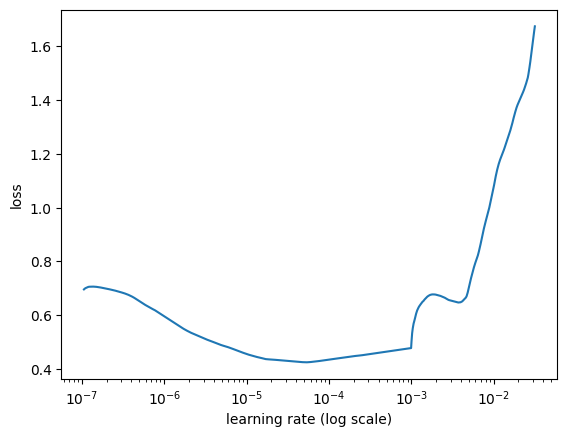

In [ ]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=4)

#Find learning rate and visually inspect loss plot and select learning rate associated with falling loss
learner.lr_find(show_plot=True, max_epochs=2)

In [ ]:
learner.reset_weights()

Model weights have been reset.


In [ ]:
LEARNING_RATE = 1e-5
EPOCHS = 2

learner.fit_onecycle(LEARNING_RATE, EPOCHS)



begin training using onecycle policy with max lr of 1e-05...
Epoch 1/2
1584/1584 [==============================] - 482s 304ms/step - loss: 0.2844 - accuracy: 0.8744 - val_loss: 0.2123 - val_accuracy: 0.9129
Epoch 2/2
1584/1584 [==============================] - 481s 303ms/step - loss: 0.1899 - accuracy: 0.9255 - val_loss: 0.1895 - val_accuracy: 0.9173


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc = t)
predict = predictor.predict(test['tweet'].to_numpy())

In [ ]:
submission = pd.DataFrame({'id': test['id'], 'label': predict}, columns= ['id', 'label'])
submission.to_csv('submit.csv', index=False)

In [ ]:
learner.validate(class_names=t.get_classes())

50/50 [==============================] - 9s 175ms/step
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1152
           1       0.82      0.89      0.85       432

    accuracy                           0.92      1584
   macro avg       0.89      0.91      0.90      1584
weighted avg       0.92      0.92      0.92      1584



array([[1068,   84],
       [  47,  385]])